**Notebook credit**: based on the original [here](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter10_dl-for-timeseries.ipynb)

# Deep learning for timeseries

- **timeseries**: any data obtained via measurements at regular intervals, like the daily price of a stock, the hourly electricity consumption of a city, or the weekly sales of a store
- Timeseries are everywhere
  - natural phenomena like seismic activity, the evolution of fish populations in a river, or the weather at a location
  - human activity patterns like visitors to a website, a country’s GDP, or credit card transactions
- Working with timeseries involves understanding the **dynamics** of a system
  - its periodic cycles
  - how it trends over time
  - its regular regime
  - its sudden spikes.

## Different kinds of timeseries tasks

- **Forecasting**: predicting what will happen next in a series
  - Forecast electricity consumption a few hours in advance so you can anticipate demand
  - forecast revenue a few months in advance so you can plan your budget
  - forecast the weather a few days in advance so you can plan your schedule
- **Classification**: Assign one or more categorical labels to a timeseries
  - given the timeseries of the activity of a visitor on a website, classify whether the visitor is a bot or a human.
- **Event detection**: Identify the occurrence of a specific expected event within a continuous data stream.
  - A particularly useful application is “hotword detection,” where a model monitors an audio stream and detects utterances like "Ok Google" or "Hey Siri" or "Alexa"
- **Anomaly detection**: Detect anything unusual happening within a continuous datastream.
  - Unusual activity on your corporate network? Might be an attacker.
  - Unusual readings on a manufacturing line? Time for a human to go take a look.
  - Anomaly detection is typically done via unsupervised learning, because you often don’t know what kind of anomaly you’re looking for, so you can’t train on specific anomaly examples.

We will focus on forecasting in this notebook. We'll learn about **recurrent neural networks (RNNs)** and how to apply them to **timeseries forecasting**.


# A temperature-forecasting example

- We will target a single problem: predicting the temperature 24 hours in the future
- given a timeseries of hourly measurements of quantities such as atmospheric pressure and humidity, recorded by a set of sensors on the roof of a building
- it’s a fairly challenging problem!
- We’ll use this temperature-forecasting task to highlight what makes timeseries data fundamentally different from the kinds of datasets you’ve encountered so far
- densely connected networks and convolutional networks aren’t well-equipped to deal with this kind of dataset
- a different kind of machine learning technique—recurrent neural networks (RNNs)—really shines on this type of problem


## The Jena Dataset

- weather timeseries dataset recorded at the weather station at the Max Planck Institute for Biogeochemistry in Jena, Germany
- 14 different quantities (such as temperature, pressure, humidity, wind direction, and so on) were recorded every 10 minutes over several years
- The original data goes back to 2003
- but the subset of the data we’ll download is limited to 2009–2016.

Let’s start by downloading and uncompressing the data:

In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2022-11-29 15:43:16--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.194.224, 52.217.166.48, 54.231.236.0, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.194.224|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip.1’

jena_climate_2009_2 100%[===================>]  12.94M  14.0MB/s    in 0.9s    

2022-11-29 15:43:17 (14.0 MB/s) - ‘jena_climate_2009_2016.csv.zip.1’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
replace jena_climate_2009_2016.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: jena_climate_2009_2016.csv  
replace __MACOSX/._jena_climate_2009_2016.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**Inspecting the data of the Jena weather dataset**

In [31]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

In [32]:
with open(fname) as f:
  data = f.read()

In [33]:
lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
# print(header, len(lines))

**Parsing the data**

- let us convert all 420,451 lines of data into NumPy arrays
- one array for the year (extracted from Date Time)
- one array for the temperature (in degrees Celsius)
- one 2-d array for the rest of the data—the features we will use to predict future temperatures

In [34]:
import numpy as np 
temperature = np.zeros((len(lines), ))
year = np.zeros((len(lines), ))

raw_data = np.zeros((len(lines), len(header) - 1))

In [35]:
for i, line in enumerate(lines):
  year[i] = int(line.split(",")[0].split(".")[2].split(" ")[0])
  values = [float(x) for x in line.split(",")[1:]]
  temperature[i] = values[1]
  raw_data[i, :] = values[:]

**Plotting the temperature timeseries**

- in the plot below, you can clearly see the yearly periodicity of temperature
- the data spans 8 years

In [36]:
raw_data.shape

(420451, 14)

In [37]:
year.shape

(420451,)

In [38]:
temperature.shape

(420451,)

**Plotting the first 10 days of the temperature timeseries**

- Plot below shows a more narrow plot of the first 10 days of temperature data
- Because the data is recorded every 10 minutes, you get 24 × 6 = 144 data points per day

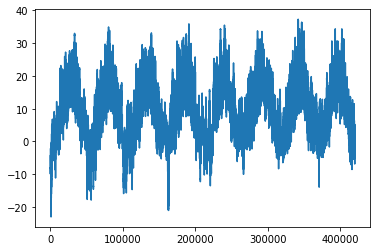

In [39]:
import matplotlib.pyplot as plt

plt.plot(range(len(temperature)), temperature)

## Restricting to 2009 data

Let us restrict ourselves to data from 2009 only for our models to train faster on free colab resources

In [40]:
condition = (year == 2009)
raw_data = raw_data[condition]
temperature = temperature[condition]

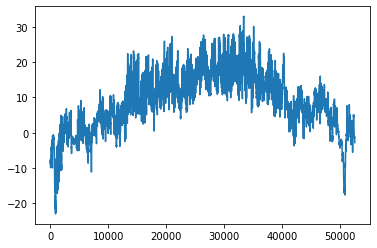

In [41]:
plt.plot(range(len(temperature)), temperature)

In [42]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = int(0.25 * len(raw_data))
print(num_train_samples, num_test_samples, num_val_samples)

26278 13139 13139


**Computing the number of samples we'll use for each data split**

- we’ll use the first 50% of the data for training
- the following 25% for validation
- the last 25% for testing
- When working with timeseries data, it’s important to use validation and test data that is more recent than the training data
- because you’re trying to predict the future given the past, not the reverse
- your validation/test splits should reflect that

In [43]:
mean = raw_data[:num_train_samples].mean(axis = 0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis = 0)
raw_data /= std

### Preparing the data

The exact formulation of the problem will be as follows:

**Given data covering the previous five days and sampled once per hour, can we predict the temperature 24 hours in advance?**

- each timeseries in the data is on a different scale (for example, atmospheric pressure, measured in mbar, is around 1,000, while H2OC, measured in millimoles per mole, is around 3)
- We’ll normalize each timeseries independently so that they all take small values on a similar scale
- We’re going to use the first 26,278 timesteps as training data, so we’ll compute the mean and standard deviation only on this fraction of the data.

**Normalizing the data**

- let’s create a `Dataset` object that yields batches of data from the past five days along with a target temperature 24 hours in the future
- Because the samples in the dataset are highly redundant (sample $N$ and sample $N + 1$ will have most of their time-steps in common), it would be wasteful to explicitly allocate memory for every sample.
- Instead, we’ll generate the samples on the fly while only keeping in memory the original `raw_data` and `temperature` arrays, and nothing more.
- We could easily write a Python generator to do this, but there’s a built-in dataset utility in Keras that does just that
- we can save ourselves some work by using `timeseries_dataset_from_array()`
- You can generally use it for any kind of timeseries forecasting task.

## Understanding `timeseries_dataset_from_array()`

- The general idea is that you provide an array of timeseries data (the `data` argument), and `timeseries_dataset_from_array()` gives you windows extracted from the original timeseries (we’ll call them “sequences”)
- For example, if you use `data = [0 1 2 3 4 5 6]` and `sequence_length=3`, then timeseries_dataset_from_array() will generate the following samples: `[0 1 2], [1 2 3], [2 3 4], [3 4 5], [4 5 6]`.
- You can also pass a `targets` argument (an array) to `timeseries_dataset_ from_array()`
  - The first entry of the targets array should match the desired target for the first sequence that will be generated from the data array.
  - So if you’re doing timeseries forecasting, targets should be the same array as data, offset by some amount.
- For instance, with `data=[0 1 2 3 4 5 6 ...]` and `sequence_length=3`, you could create a dataset to predict the next step in the series by passing `targets=[3 4 5 6 ...]`

Let’s try it:

In [44]:
import numpy as np 
from tensorflow import keras
int_sequence = np.arange(10)

dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data = int_sequence[:-3],
    targets = int_sequence[:3], 
    sequence_length = 3, 
    batch_size = 2
)

In [45]:
for inputs, targets in dummy_dataset:
  for i in range(inputs.shape[0]):
    print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 0
[1, 2, 3] 1
[2, 3, 4] 2


**Instantiating datasets for training, validation, and testing**

- We’ll use `timeseries_dataset_from_array()` to instantiate three datasets:
  - one for training, one for validation, and one for testing.
- We’ll use the following parameter values:
  - `sampling_rate = 6`: Observations will be sampled at one data point per hour: we will only keep one data point out of 6.
 - `sequence_length = 120`: Observations will go back 5 days (120 hours)
 - `delay = sampling_rate * (sequence_length + 24 - 1)`: The target for a sequence will be the temperature 24 hours after the end of the sequence.
- When making the training dataset, we’ll pass `start_index = 0` and `end_index = num_train_samples` to only use the first 50% of the data.
- For the validation dataset, we’ll pass `start_index = num_train_samples` and `end_index = num_train_samples + num_val_samples` to use the next 25% of the data.
- Finally, for the test dataset, we’ll pass `start_index=num_train_samples+num_val_samples` to use the remaining samples.

In [46]:
sampling_rate = 6
sequence_length = 120 
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

In [47]:
train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay], 
    targets = temperature[delay:],
    sampling_rate = sampling_rate, 
    sequence_length = sequence_length, 
    shuffle = True, 
    start_index = 0, 
    end_index = num_train_samples
)

In [48]:
val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True, # randomly shuffle the output samples instead of drawing them in chronological order
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples
)

In [49]:
test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True, # randomly shuffle the output samples instead of drawing them in chronological order
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples
)

**Inspecting the output of one of our datasets**

- Each dataset yields a tuple `(samples, targets)`, where
  - `samples` is a batch of 256 samples, each containing 120 consecutive hours of input data
  - `targets` is the corre-sponding array of 256 target temperatures
  
Note that because we used `shuffle=True`, the samples are randomly shuffled, so two consecutive sequences in a batch (like `samples[0]` and `samples[1]`) aren’t necessarily temporally close.

In [50]:
for samples, targets in train_dataset:
  print("samples shape", samples.shape)
  print("targets shape", targets.shape)
  break

samples shape (128, 120, 14)
targets shape (128,)


## A common-sense, non-machine-learning baseline

**Computing the common-sense baseline MAE**


- Before we start using deep learning, let’s try a simple, common-sense approach.
- Such common-sense base- lines can be useful when you’re approaching a new problem for which there is no known solution (yet).
- A classic example is that of unbalanced classification tasks, where some classes are much more common than others.
- If your dataset contains 90% instances of class A and 10% instances of class B, then a common-sense approach to the classification task is to always predict “A” when presented with a new sample.
- Such a classifier is 90% accurate overall, and any learning-based approach should therefore beat this 90% score in order to demonstrate usefulness
- **Sometimes, such elementary baselines can prove surprisingly hard to beat.**
- In this case, a common-sense approach is to always predict that the temperature 24 hours from now will be equal to the temperature right now. Let’s evaluate this approach, using the mean absolute error (MAE) metric, defined as follows:
```
np.mean(np.abs(preds - targets))
```
Here’s the evaluation loop.

In [51]:
def evaluate_naive_method(dataset):
  total_abs_err = 0 
  samples_seen = 0 
  for samples, targets in dataset:
    preds = samples[:, -1, 1] * std[1] + mean[1]
    total_abs_err  += np.sum(np.abs(preds - targets))
    samples_seen += samples.shape[0]
  return total_abs_err / samples_seen

In [52]:
print(f"Validate MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Validate MAE: {evaluate_naive_method(test_dataset):.2f}")

Validate MAE: 2.68
Validate MAE: 2.59


- common-sense baseline achieves:
  - a validation MAE of 2.68 degrees Celsius
  - a test MAE of 2.59 degrees Celsius
- So, if you always assume that the temperature 24 hours in the future will be the same as it is now, you will be off by two and a half degrees on average.
- It’s not too bad, but you probably won’t launch a weather forecasting service based on this heuristic!
- Let's see if we can use deep learning to do better.

## Let's try a basic machine-learning model

- it’s useful to establish a common-sense baseline before trying machine learning approaches
- similarly, it’s useful to try simple, cheap machine learning models (such as small, densely connected networks) before looking into complicated and computationally expensive models such as RNNs
- This is the best way to make sure any further complexity you throw at the problem is legitimate and delivers real benefits.
- The following listing shows a fully connected model that starts by flattening the data and then runs it through two Dense layers.
- Note the lack of an activation function on the last Dense layer, which is typical for a regression problem.
- We use mean squared error (MSE) as the loss, rather than MAE, because unlike MAE, it’s smooth around zero, which is a useful property for gradient descent.
- We will monitor MAE by adding it as a metric in `compile()`.

**Training and evaluating a densely connected model**

In [53]:
from tensorflow import keras 
from tensorflow.keras import layers

In [54]:
inputs = keras.Input(shape = (sequence_length, raw_data.shape[-1]))

x = layers.Flatten()(inputs)
x = layers.Dense(16, activation = 'relu')(x)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

In [55]:
callbacks = [
    keras.callbacks.ModelCheckpoint('jena_dense.keras', save_best_only = True)
]

In [56]:
model.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae'])
history = model.fit(train_dataset, epochs = 5, validation_data = val_dataset, callbacks = callbacks)

Epoch 1/5
200/200 [==============================] - 7s 32ms/step - loss: 13.4661 - mae: 2.7559 - val_loss: 30.5675 - val_mae: 4.6218
Epoch 2/5
200/200 [==============================] - 7s 33ms/step - loss: 6.3322 - mae: 1.9573 - val_loss: 18.8479 - val_mae: 3.4862
Epoch 3/5
200/200 [==============================] - 7s 35ms/step - loss: 5.0311 - mae: 1.7418 - val_loss: 16.4847 - val_mae: 3.2299
Epoch 4/5
200/200 [==============================] - 10s 49ms/step - loss: 4.2139 - mae: 1.5869 - val_loss: 16.4901 - val_mae: 3.2040
Epoch 5/5
200/200 [==============================] - 8s 40ms/step - loss: 3.7079 - mae: 1.4920 - val_loss: 19.6638 - val_mae: 3.6024


In [57]:
model = keras.models.load_model('jena_dense.keras')
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

46/46 [==============================] - 2s 35ms/step - loss: 25.9692 - mae: 3.7594
Test MAE: 3.76


**Plotting results**

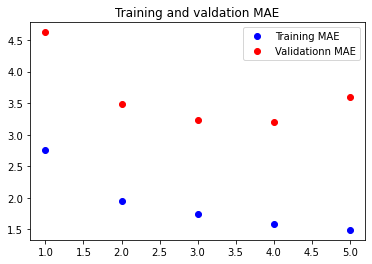

In [58]:
import matplotlib.pyplot as plt

loss = history.history['mae']
val_loss = history.history['val_mae']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training MAE')
plt.plot(epochs, val_loss, 'ro', label = 'Validationn MAE')
plt.title('Training and valdation MAE')
plt.legend()
plt.show()

- Validation losses are worse than the no-learning baseline
- This goes to show the merit of having this baseline in the first place: it turns out to be not easy to outperform
- common sense contains a lot of valuable information to which a machine learning model doesn’t have access


### How can dense network do worse than simple base line?

- if a simple, well-performing model exists to go from the data to the targets (the common-sense baseline), why doesn’t the model we’re training find it and improve on it?
- the space of models in which you’re searching for a solution— that is, your *hypothesis space*—is the space of all possible two-layer networks with the configuration you defined.
- The common-sense heuristic is just one model among millions that can be represented in this space
- It’s like looking for a needle in a haystack.
- **Just because a good solution technically exists in your hypothesis space doesn’t mean you’ll be able to find it via gradient descent.**
- That’s a pretty significant limitation of machine learning in general
- unless the learning algorithm is hardcoded to look for a specific kind of simple model, it can sometimes fail to find a simple solution to a simple problem
- That’s why leveraging good feature engineering and relevant architecture priors is essential: you need to precisely tell your model what it should be looking for.

## Let's try a 1D convolutional model

- You already know about the `Conv2D` layers, which see their inputs through small windows that swipe across 2D grids.
- There are also 1D and even 3D versions of these layers: `Conv1D` and `Conv3D`.
- The `Conv1D` layer relies on 1D windows that slide across input sequences, and the `Conv3D` layer relies on cubic windows that slide across input volumes.
- You can thus build 1D convnets, strictly analogous to 2D convnets.
- They’re a great fit for any sequence data that follows the translation invariance assumption (meaning that if you slide a window over the sequence, the content of the window should follow the same properties independently of the location of the window).
- Let’s try one on our temperature-forecasting problem.
- We’ll pick an initial window length of 24, so that we look at 24 hours of data at a time (one cycle).
- As we downsample the sequences (via `MaxPooling1D` layers), we’ll reduce the window size accordingly:

In [59]:
inputs = keras.Input(shape = (sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation = 'relu')(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation = 'relu')(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation = 'relu')(x)
x = layers.MaxPooling1D(2)(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [60]:
callbacks = [
    keras.callbacks.ModelCheckpoint('jena_conv.keras', save_best_only=True)
]

In [61]:
model.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae'])
history = model.fit(train_dataset, epochs = 5, validation_data = val_dataset, callbacks = callbacks)

Epoch 1/5
200/200 [==============================] - 12s 55ms/step - loss: 22.2547 - mae: 3.6230 - val_loss: 33.3971 - val_mae: 4.5853
Epoch 2/5
200/200 [==============================] - 14s 68ms/step - loss: 16.0868 - mae: 3.1148 - val_loss: 38.6853 - val_mae: 4.9625
Epoch 3/5
200/200 [==============================] - 19s 92ms/step - loss: 14.7031 - mae: 2.9500 - val_loss: 50.4763 - val_mae: 5.7238
Epoch 4/5
200/200 [==============================] - 12s 60ms/step - loss: 13.8725 - mae: 2.8700 - val_loss: 49.1534 - val_mae: 5.6488
Epoch 5/5
200/200 [==============================] - 16s 77ms/step - loss: 13.3161 - mae: 2.8114 - val_loss: 32.9984 - val_mae: 4.5968


In [62]:
model = keras.models.load_model('jena_conv.keras')
print(f"Test MAE:  {model.evaluate(test_dataset)[1]:.2f}")

46/46 [==============================] - 4s 78ms/step - loss: 37.4708 - mae: 4.7176
Test MAE:  4.72


**The 1D convolution model performs even worse than the densely connected one**

Test MAE is higher than 4 degrees, far from the common-sense baseline. What went wrong here? Two things:
- First, weather data doesn’t quite respect the translation invariance assumption. While the data does feature daily cycles, data from a morning follows different properties than data from an evening or from the middle of the night. Weather data is only translation-invariant for a very specific timescale.
- Second, order in our data matters—a lot. The recent past is far more informa- tive for predicting the next day’s temperature than data from five days ago. A 1D convnet is not able to leverage this fact. **In particular, our max pooling and global average pooling layers are largely destroying order information.**

## A first recurrent baseline

- The densely connected approach first flattened the timeseries, which removed the notion of time from the input data.
- The convolutional approach treated every segment of the data in the same way, even applying pooling, which destroyed order information.
- Let’s instead look at the data as what it is: **a sequence, where causality and order matter.**
- There’s a family of neural network architectures designed specifically for this use case: **recurrent neural networks**.
- Among them, the **Long Short Term Memory (LSTM)** layer has long been very popular.
- We’ll see in a minute how these models work, but let’s start by giving the LSTM layer a try.

**A simple LSTM-based model**

In [63]:
inputs = keras.Input(shape = (sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [64]:
callbacks = [
    keras.callbacks.ModelCheckpoint('jena_lstm.keras', save_best_only = True)
]

In [65]:
model.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae'])

history = model.fit(train_dataset, epochs = 5, validation_data = val_dataset, callbacks = callbacks)

Epoch 1/5
200/200 [==============================] - 18s 78ms/step - loss: 69.2562 - mae: 6.5238 - val_loss: 129.5052 - val_mae: 10.2527
Epoch 2/5
200/200 [==============================] - 15s 76ms/step - loss: 34.2342 - mae: 4.3729 - val_loss: 73.0390 - val_mae: 7.1517
Epoch 3/5
200/200 [==============================] - 16s 78ms/step - loss: 19.3517 - mae: 3.2672 - val_loss: 38.8106 - val_mae: 4.8233
Epoch 4/5
200/200 [==============================] - 17s 83ms/step - loss: 12.3163 - mae: 2.6320 - val_loss: 21.8626 - val_mae: 3.5252
Epoch 5/5
200/200 [==============================] - 15s 76ms/step - loss: 9.7582 - mae: 2.3644 - val_loss: 16.0485 - val_mae: 3.0414


In [66]:
model = keras.models.load_model('jena_lstm.keras')
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

46/46 [==============================] - 3s 51ms/step - loss: 13.5830 - mae: 2.8509
Test MAE: 2.85


We achieve a test MAE of about 2.8 degrees. The LSTM-based model didn't beat the common-sense baseline but it did much better than other deep learning models.

- Why did the LSTM model perform markedly better than the densely connected one or the convnet?
- And how can we further refine the model?
- To answer this, we will take a closer look at recurrent neural networks.

# Understanding recurrent neural networks


- all neural networks you’ve seen so far, such as densely connected networks and convnets, have **no memory**.
- Each input shown to them is processed independently, with no **state** kept between inputs.
- With such networks, in order to process a sequence or a temporal series of data points, you have to show the entire sequence to the network at once: turn it into a single data point.
  - For instance, this is what we did in the densely connected network example: we flattened our five days of data into a single large vector and processed it in one go.
  - Such networks are called **feedforward networks**.

- Think about how we read text
- We process it word by word—or rather, eye saccade by eye saccade—while keeping memories of what came before
- this gives you a fluid representation of the meaning conveyed by this sentence.
- Biological intelligence processes information incrementally while maintaining an internal model of what it’s processing, built from past information and constantly updated as new information comes in.
- A recurrent neural network (RNN) adopts the same principle, albeit in an extremely simplified version:
  - it processes sequences by iterating through the sequence elements and maintaining a state that contains information relative to what it has seen so far.
  - In effect, an RNN is a type of neural network that has an internal loop (see figure below).

<img src="https://github.com/ambujtewari/stats315-winter2022/raw/main/images/RNN.png" width="400">

- state of the RNN is reset between processing two different, independent sequences (such as two samples in a batch)
- so you still consider one sequence to be a single data point: a single input to the network.
- What changes is that this data point is no longer processed in a single step; rather, the network internally loops over sequence elements.


To make these notions of *loop* and *state* clear, let’s implement the forward pass of a toy RNN.

**NumPy implementation of a simple RNN**

In [67]:
import numpy as np

timesteps = 100 
input_features = 32 
output_features = 64

In [68]:
inputs = np.random.random((timesteps, input_features))

state_t = np.zeros((output_features,))

W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))

sucessive_outputs = []

for input_t in inputs:
  output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
  sucessive_outputs.append(output_t)

  state_t = output_t

final_output_sequence = np.stack(sucessive_outputs, axis = 0)


- In this example, the final output is a rank-2 tensor of shape `(timesteps,output_features)`, where each timestep is the output of the loop at time t.
- Each timestep `t` in the output tensor contains information about timesteps `0` to `t` in the input sequence—about the entire past.
- For this reason, in many cases, you don’t need this full sequence of outputs; you just need the last output (`output_t` at the end of the loop), because it already contains information about the entire sequence.

### A recurrent layer in Keras

- The process we just naively implemented in NumPy corresponds to an actual Keras layer—the `SimpleRNN` layer.
- There is one minor difference: `SimpleRNN` processes **batches** of sequences, like all other Keras layers, not a single sequence as in the NumPy example.
- This means it takes inputs of shape `(batch_size, timesteps, input_features)`, rather than `(timesteps, input_features)`.
- When specifying the shape argument of the initial `Input()`, note that you can set the timesteps entry to `None`, which enables your network to process sequences of arbitrary length.

**An RNN layer that can process sequences of any length**

In [69]:
num_features = 14
inputs = keras.Input(shape = (None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

- This is especially useful if your model is meant to process sequences of variable length.
- However, if all of your sequences have the same length, it is recommended that you specify a complete input shape
  - it enables `model.summary()` to display output length information, which is always nice
  - it can unlock some performance optimizations

- All recurrent layers in Keras (`SimpleRNN`, `LSTM`, and `GRU`) can be run in two different modes:
  - they can return either full sequences of successive outputs for each timestep (a rank-3 tensor of shape `(batch_size, timesteps, output_features)`), or
  - return only the last output for each input sequence (a rank-2 tensor of shape `(batch_ size, output_features)`).
- These two modes are controlled by the `return_sequences` constructor argument.
- Let’s look at an example that uses `SimpleRNN` and returns only the output at the last timestep.


**An RNN layer that returns only its last output step**

In [70]:
num_features = 14 
steps = 120
inputs = keras.Input(shape = (steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences = False)(inputs)
# return_sequences = false is the default

The following example returns the full state sequence.

**An RNN layer that returns its full output sequence**

In [71]:
inputs = keras.Input(shape = (steps, num_features))

x = layers.SimpleRNN(16, return_sequences = True)(inputs)
x = layers.SimpleRNN(16, return_sequences = True)(x)
outputs = layers.SimpleRNN(16)(x)

- It’s sometimes useful to stack several recurrent layers one after the other in order to increase the representational power of a network.
- In such a setup, you have to get all of the intermediate layers to return a full sequence of outputs.


**Stacking RNN layers**

### LSTM layers

- `SimpleRNN` layer is generally too simplistic to be of real use.
- major issue: although it should theoretically be able to retain at time `t` information about inputs seen many timesteps before, such long-term dependencies prove impossible to learn in practice.
- This is due to the **vanishing gradient problem**, an effect that is similar to what is observed with non-recurrent networks (feedforward networks) that are many layers deep:
  - as you keep adding layers to a network, the network eventually becomes untrainable.
- `LSTM` and `GRU` were designed to address these issues.

Let’s consider the LSTM layer. The underlying Long Short-Term Memory (LSTM) algorithm was developed by [Hochreiter and Schmidhuber in 1997](https://doi.org/10.1162/neco.1997.9.8.1735); it was the culmi- nation of their research on the vanishing gradient problem.


- This layer is a variant of the `SimpleRNN` layer you already know about
- it adds a way to carry information across many timesteps
- Imagine a conveyor belt running parallel to the sequence you’re processing
  - Information from the sequence can jump onto the conveyor belt at any point,
  - be transported to a later timestep, and
  - jump off, intact, when you need it.
- This is essentially what LSTM does: it saves information for later, thus preventing older signals from gradually vanishing during processing.


**Understanding LSTMs pictorially**

- let’s start from the SimpleRNN cell (see figure 10.8).
- Because you’ll have a lot of weight matrices, index the `W` and `U` matrices in the cell, with the letter `o` (`Wo` and `Uo`) for *output*.

<img src="https://github.com/ambujtewari/stats315-winter2022/raw/main/images/starting_point_LSTM.png" height="400">



- Let’s add an additional data flow that carries information across time- steps.
- Call its values at different timesteps `c_t`, where C stands for *carry*.
- This information will have the following impact on the cell:
  - it will be combined with the input connection and the recurrent connection (via a dense transformation: a dot product with a weight matrix followed by a bias add and the application of an activation function), and
  - it will affect the state being sent to the next timestep (via an activation function and a multiplication operation).
- Conceptually, the carry dataflow is a way to modulate the next output and the next state (see figure 10.9)

<img src="https://github.com/ambujtewari/stats315-winter2022/raw/main/images/SimpleRNN_to_LSTM.png" height="400">

- Now the subtlety—the way the next value of the carry dataflow is computed
- It involves three distinct transformations.
- All three have the form of a SimpleRNN cell:
```
y = activation(dot(state_t, U) + dot(input_t, W) + b)
```
- But all three transformations have their own weight matrices, which we’ll index with the letters `i`, `f`, and `k`. Here’s what we have so far (it may seem a bit arbitrary, but hang on for a moment!).
```
output_t = activation(dot(state_t, Uo) + dot(input_t, Wo) + dot(c_t, Vo) + bo)
i_t = activation(dot(state_t, Ui) + dot(input_t, Wi) + bi)
f_t = activation(dot(state_t, Uf) + dot(input_t, Wf) + bf)
k_t = activation(dot(state_t, Uk) + dot(input_t, Wk) + bk)
```
-We obtain the new carry state (the next `c_t`) by combining `i_t`, `f_t`, and `k_t`.
```
c_t+1 = i_t * k_t + c_t * f_t
```
- Add this as shown in figure 10.10, and that’s it.
- Not so complicated—merely a tad complex.

<img src="https://github.com/ambujtewari/stats315-winter2022/raw/main/images/anatomy_LSTM.png" height="400">


**Interpreting LSTM operations**

- you can interpret what each of these operations is meant to do.
- For instance, you can say that multiplying `c_t` and `f_t` is a way to deliberately **forget** irrelevant information in the carry dataflow.
- Meanwhile, `i_t` and `k_t` provide information about the present, updating the carry track with new information.
- But at the end of the day, these interpretations don’t mean much, because what these operations actually do is determined by the contents of the weights parameterizing them
  - the weights are learned in an end-to-end fashion, starting over with each training round, making it impossible to credit this or that operation with a specific purpose.
- The specification of an RNN cell (as just described) determines your hypothesis space—the space in which you’ll search for a good model configuration during training
- but it doesn’t determine what the cell does; that is up to the cell weights.
- The same cell with different weights can be doing very different things.
- So the combination of operations making up an RNN cell is better interpreted as **a set of constraints on your search**, not as a design in an engineering sense.
- Arguably, the choice of such constraints—the question of how to implement RNN cells—is better left to optimization algorithms (like genetic algorithms or reinforcement- learning processes) than to human engineers.
  - In the future, that’s how we’ll build our models.
- In summary: you don’t need to understand anything about the specific archi- tecture of an LSTM cell; as a human, it shouldn’t be your job to understand it.
- Just keep in mind what the LSTM cell is meant to do: allow past information to be reinjected at a later time, thus fighting the vanishing-gradient problem.

# Advanced use of recurrent neural networks

We’ll cover the following:
- *Recurrent dropout*—This is a variant of dropout, used to fight overfitting in recurrent layers.
- *Stacking recurrent layers*—This increases the representational power of the model (at the cost of higher computational loads).
- *Bidirectional recurrent layers*—These present the same information to a recurrent network in different ways, increasing accuracy and mitigating forgetting issues.



### Using recurrent dropout to fight overfitting


- You’re already familiar with a classic technique for fighting overfitting: dropout
- It randomly zeros out input units of a layer in order to break happenstance correlations in the training data that the layer is exposed to.
- But how to correctly apply dropout in recurrent networks isn’t a trivial question.


**Recurrent dropout**

- It has long been known that applying dropout before a recurrent layer hinders learning rather than helping with regularization.
- In 2016, Yarin Gal, as part of his PhD thesis on Bayesian deep learning, determined the proper way to use dropout with a recurrent network
- the same dropout mask (the same pattern of dropped units) should be applied at every timestep, instead of using a dropout mask that varies randomly from timestep to timestep.
- in order to regularize the representations formed by the recurrent gates of layers such as GRU and LSTM, a temporally constant dropout mask should be applied to the inner recurrent activations of the layer (a recurrent dropout mask)
- Using the same dropout mask at every timestep allows the network to properly propagate its learning error through time; a temporally random dropout mask would disrupt this error signal and be harmful to the learning process.
- Every recurrent layer in Keras has two dropout-related arguments:
  - `dropout`, a float specifying the dropout rate for input units of the layer, and
  - `recurrent_dropout`, specifying the dropout rate of the recurrent units. 


**Adding recurrent dropout to our first LSTM example**

- Let’s add recurrent dropout to the LSTM layer of our first LSTM example and see how doing so impacts overfitting.
- Thanks to dropout, we won’t need to rely as much on network size for regularization, so we can use an LSTM layer with twice as many units, which should, hopefully, be more expressive
  - without dropout, this network would have started overfitting right away—try it
- Because networks being regularized with dropout always take much longer to fully converge, we need to train the model longer. The performance below isn't as good because we're only running 10 epochs.

**Training and evaluating a dropout-regularized LSTM**

### Stacking recurrent layers

- Increasing network capacity is typically done by increasing the number of units in the layers or adding more layers.
- **Recurrent layer stacking** is a classic way to build more-powerful recurrent networks:
  - for instance, not too long ago the Google Translate algorithm was powered by a stack of seven large LSTM layers—that’s huge.
- To stack recurrent layers on top of each other in Keras, all intermediate layers should return their full sequence of outputs (a rank-3 tensor) rather than their output at the last timestep.
  - As you’ve already learned, this is done by specifying `return_sequences=True`.
- we’ll try a stack of two dropout-regularized recurrent layers.
- For a change, we’ll use Gated Recurrent Unit (GRU) layers instead of LSTM.
- GRU is very similar to LSTM—you can think of it as a slightly simpler, streamlined version of the LSTM architecture.
  - It was introduced in 2014 by [Cho et al.](https://arxiv.org/abs/1409.1259) when recurrent networks were just starting to gain interest anew

**Training and evaluating a dropout-regularized, stacked GRU model**

In [72]:
inputs = keras.Input(shape = (sequence_length, raw_data.shape[-1]))

# what is the drop out rate within recurrent relationship? ensure we drop out the same thing over time 
x = layers.LSTM(32, recurrent_dropout = 0.25)(inputs)
# regularizing the dense layer after this 
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

In [73]:
inputs = keras.Input(shape = (sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout = 0.5, return_sequences = True)(inputs)
x = layers.GRU(32, recurrent_dropout = 0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

In [74]:
callbacks = [
    keras.callbacks.ModelCheckpoint('jena_lstm_dropout.keras', save_best_only = True)
]

model.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae'])

history = model.fit(train_dataset, epochs = 2, validation_data = val_dataset, callbacks = callbacks)

Epoch 1/2
200/200 [==============================] - 58s 266ms/step - loss: 34.3836 - mae: 4.4137 - val_loss: 40.0225 - val_mae: 4.9305
Epoch 2/2
200/200 [==============================] - 52s 260ms/step - loss: 14.8493 - mae: 2.9665 - val_loss: 19.3685 - val_mae: 3.3301


In [75]:
loss = history.history['mae']

In [76]:
model = keras.model.load_model('jena_stacked_gru_dropout.keras')
print(f"test mae: {model.evaluate(test_dataset[1])}")

AttributeError: ignored

We achieve a test MAE of 2.7 which is better than what vanilla LSTM gave us. It's still slightly higher than the test MAE of the non-ML baseline.

### Using bidirectional RNNs

- RNNs are notably order-dependent: they process the timesteps of their input sequences in order, and shuffling or reversing the timesteps can completely change the representations the RNN extracts from the sequence.
- This is precisely the reason they perform well on problems where order is meaningful, such as the temperature-forecasting problem.
- A bidirectional RNN exploits the order sensitivity of RNNs: it uses two regular RNNs, such as the GRU and LSTM layers you’re already familiar with, each of which processes the input sequence in one direction (chronologically and antichronologically), and then merges their representations.
- By processing a sequence both ways, a bidirectional RNN can catch patterns that may be overlooked by a unidirectional RNN.

<img src="https://github.com/ambujtewari/stats315-winter2022/raw/main/images/bidirectional_RNN.png" width="400"> 

**Training and evaluating a bidirectional LSTM**

In [78]:
inputs = keras.Input(shape = (sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
output = layers.Dense(1)(x)
model = keras.Model(inputs, output)


- it doesn’t perform as well as the plain LSTM layer.
- all the predictive capacity must come from the chronological half of the network
- the antichronological half is known to be severely underperforming on this task (again, because the recent past matters much more than the distant past, in this case)
- however, the presence of the antichronological half doubles the network’s capacity and contributes to overfitting



**Bidirectional RNNs on text data**

- bidirectional RNNs are a great fit for text data, or any other kind of data where order matters, yet where which order you use doesn’t matter.
- for a while in 2016, bidirectional LSTMs were considered the state of the art on many natural language processing tasks (before the rise of the Transformer architecture).

### Going even further

- Adjust the number of units in each recurrent layer in the stacked setup, as well as the amount of dropout.
- Adjust the learning rate used by the `RMSprop` optimizer, or try a different optimizer.
- Try using a stack of `Dense` layers as the regressor on top of the recurrent layer, instead of a single `Dense` layer.
- Improve the input to the model: try using longer or shorter sequences or a different sampling rate, or start doing feature engineering.

## Summary

- when approaching a new problem, it’s good to first establish common-sense baselines for your metric of choice. If you don’t have a baseline to beat, you can’t tell whether you’re making real progress.
- Try simple models before expensive ones, to make sure the additional expense is justified. Sometimes a simple model will turn out to be your best option.
- When you have data where ordering matters, and in particular for timeseries data, recurrent networks are a great fit and easily outperform models that first flat- ten the temporal data.
- The two essential RNN layers available in Keras are the LSTM layer and the GRU layer.
- To use dropout with recurrent networks, you should use a time-constant dropout mask and recurrent dropout mask. These are built into Keras recurrent layers, so all you have to do is use the `recurrent_dropout` arguments of recurrent layers.
- Stacked RNNs provide more representational power than a single RNN layer. They’re also much more expensive and thus not always worth it. Although they offer clear gains on complex problems (such as machine translation), they may not always be relevant to smaller, simpler problems.